# 1. Convert json to dataframe

In [1]:
import pandas as pd
from pycocotools.coco import COCO

# COCO 데이터셋 로드
coco = COCO('./dataset/train.json')

# 데이터프레임 초기화
data = {
    "image_id": [],
    "class_name": [],
    "class_id": [],
    'id': [],
    "x_min": [],
    "y_min": [],
    "x_max": [],
    "y_max": []
}

classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    image_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)
    
    file_name = image_info['file_name']
    
    for ann in anns:
        data["image_id"].append(file_name)
        data["class_name"].append(classes[ann['category_id']])
        data["class_id"].append(ann['category_id'])
        data['id'].append(ann['id'])
        data["x_min"].append(float(ann['bbox'][0]))
        data["y_min"].append(float(ann['bbox'][1]))
        data["x_max"].append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        data["y_max"].append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

# 데이터프레임에 데이터 추가
train_df = pd.DataFrame(data)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


# 2. Check dataframe

In [2]:
train_df

,image_id,class_name,class_id,id,x_min,y_min,x_max,y_max
0,train/0000.jpg,General trash,0,0,197.6,193.7,745.4,663.4
1,train/0001.jpg,Metal,3,1,0.0,407.4,57.6,588.0
2,train/0001.jpg,Plastic bag,7,2,0.0,455.6,144.6,637.2
3,train/0001.jpg,Glass,4,3,722.3,313.4,996.6,565.3
4,train/0001.jpg,Plastic,5,4,353.2,671.0,586.9,774.4
...,...,...,...,...,...,...,...,...
23139,train/4882.jpg,Plastic,5,23139,0.0,116.2,944.1,930.3
23140,train/4882.jpg,Plastic bag,7,23140,302.1,439.3,567.3,655.4
23141,train/4882.jpg,General trash,0,23141,511.3,451.1,570.0,481.3
23142,train/4882.jpg,Paper,1,23142,255.0,421.4,526.7,616.5


# 3. Sampling

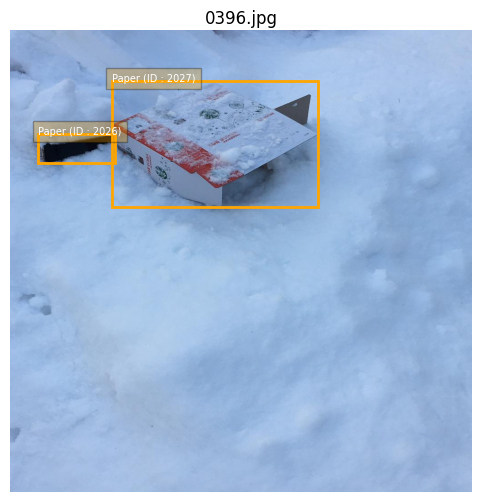

Image ID: train/0396.jpg
Bbox 개수: 2


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import os

# 데이터셋 경로 설정
BASE_DIR = './dataset'

# 바운딩 박스 색상 설정 (클래스명에 따라)
class_colors = {
    "General trash": "red", 
    "Paper": "orange", 
    "Paper pack": "yellow", 
    "Metal": "green", 
    "Glass": "blue", 
    "Plastic": "purple", 
    "Styrofoam": "cyan", 
    "Plastic bag": "magenta", 
    "Battery": "pink", 
}

# bbox를 포함하는 sample
def plot_sample_with_bbox(image_path, bbox):
    # 이미지 로드
    img = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 이미지 표시
    ax.imshow(img)
    ax.axis('off')
    
    # Bbox 그리기
    for _bbox_info in bbox:
        x, y, w, h, class_name, id = _bbox_info
        color = class_colors.get(class_name, 'yellow')  # 기본 색상은 노란색
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f"{class_name} (ID : {id})", fontsize=7, color='white', bbox=dict(facecolor=color, alpha=0.3))

    plt.title(os.path.basename(image_path), loc='center', pad=5)
    plt.axis('off')
    plt.show()
    
# bbox anchor을 coco 형태로 재구성
def bbox_anchor(Dataframe):
    # x, y, w, h
    bbox_anchor_info = [Dataframe['x_min'], 
                        Dataframe['y_min'], 
                        Dataframe['x_max'] - Dataframe['x_min'], 
                        Dataframe['y_max'] - Dataframe['y_min']]
    
    return bbox_anchor_info

# 데이터셋에서 랜덤하게 샘플 선택
sample_index = random.randint(0, len(train_df) - 1)
sample_row = train_df.iloc[sample_index]

# 이미지 경로와 Bbox 정보 추출
image_path = os.path.join(BASE_DIR, sample_row['image_id'])
sample_img_df = train_df[train_df['image_id'] == sample_row['image_id']]

# 해당 sample의 모든 bbox anchor
bbox_set = []

for idx in range(len(sample_img_df)):
    bbox_info = bbox_anchor(sample_img_df.iloc[idx])
    class_name = sample_img_df.iloc[idx]['class_name']
    id = sample_img_df.iloc[idx]['id']
    bbox_set.append((*bbox_info, class_name, id))

# 샘플 이미지와 Bbox 표시
plot_sample_with_bbox(image_path, bbox_set)

print(f"Image ID: {sample_row['image_id']}")
print(f"Bbox 개수: {len(bbox_set)}")


# 4. Save Sample images

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 데이터셋 경로 설정
BASE_DIR = './dataset'
OUTPUT_DIR = './output'  # 결과 저장할 경로

# 결과 저장 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 바운딩 박스 색상 설정 (클래스명에 따라)
class_colors = {
    "General trash": "red", 
    "Paper": "orange", 
    "Paper pack": "yellow", 
    "Metal": "green", 
    "Glass": "blue", 
    "Plastic": "purple", 
    "Styrofoam": "cyan", 
    "Plastic bag": "magenta", 
    "Battery": "pink", 
    "Clothing": "brown"
}

# bbox anchor을 coco 형태로 재구성
def bbox_anchor(Dataframe):
    # x, y, w, h
    bbox_anchor_info = [
        Dataframe['x_min'], 
        Dataframe['y_min'], 
        Dataframe['x_max'] - Dataframe['x_min'], 
        Dataframe['y_max'] - Dataframe['y_min']
    ]
    return bbox_anchor_info

# 이미지 ID에서 숫자 부분 추출
def extract_image_id(image_id):
    return int(os.path.splitext(os.path.basename(image_id))[0])

# 모든 이미지에 bbox 적용
def save_images_with_bbox(train_df):
    for image_id in train_df['image_id'].unique():
        # 특정 이미지 ID부터 시작
        if extract_image_id(image_id) < 4316:
            continue

        image_path = os.path.join(BASE_DIR, image_id)
        sample_img_df = train_df[train_df['image_id'] == image_id]

        # 이미지 로드
        img = Image.open(image_path)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(img)
        ax.axis('off')

        # 해당 sample의 모든 bbox anchor
        bbox_set = []

        for idx in range(len(sample_img_df)):
            bbox_info = bbox_anchor(sample_img_df.iloc[idx])
            class_name = sample_img_df.iloc[idx]['class_name']
            id = sample_img_df.iloc[idx]['id']
            bbox_set.append((*bbox_info, class_name, id))

            # Bbox 색상 설정
            color = class_colors.get(class_name, 'yellow')  # 기본 색상은 노란색

            # Bbox 그리기
            x, y, w, h = bbox_info
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f"{class_name} (ID : {id})", fontsize=7, color='white', bbox=dict(facecolor=color, alpha=0.4))

        # 이미지 제목 추가
        plt.title(os.path.basename(image_path), loc='center', pad=5)
        
        # JPG 파일로 저장
        output_image_path = os.path.join(OUTPUT_DIR, os.path.splitext(image_id)[0] + '_bbox.jpg')
        plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # 메모리 절약을 위해 닫기

# 모든 이미지에 바운딩 박스를 그려서 저장
save_images_with_bbox(train_df)

print(f"All images with bounding boxes have been saved to {OUTPUT_DIR}.")


All images with bounding boxes have been saved to ./output.
